# Code

In [80]:
import sys
sys.path.append('../..')

from shapely.geometry import Point, Polygon
from shapely.affinity import affine_transform
import matplotlib.pyplot as plt

from research_envs.path_planning.descartes_mod.patch import PolygonPatch

import re

# Function to extract vertices from SVG path data
def extract_vertices(svg_path_data):
    # Use regular expression to find all numeric coordinates
    coordinates = re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', svg_path_data)

    # Convert the coordinates to float and group them by pairs (x, y)
    vertices = [(float(coordinates[i]), float(coordinates[i+1])) for i in range(0, len(coordinates), 2)]

    return vertices


def plot_map(obs_set, x_rng, y_rng):
    """
    Mostra o mapa de polígonos Shapely
    """
    fig = plt.figure(figsize=(8,5), dpi=100)
    ax = fig.add_subplot(111, aspect='equal') 

    for obs in obs_set:
        #print(obs)
        ax.add_patch(PolygonPatch(obs, facecolor='gray'))
        
    ax.set_xlim(x_rng[0], x_rng[1])
    ax.set_ylim(y_rng[0], y_rng[1])
    plt.show()

# SVG

In [9]:
shape_name = 'tentacle'
# Given SVG path data
svg_path_data = "F M93.7734375 83.88671875 L124.22265625 53.78515625 L159.61328125 55.39453125 L149.2890625 16.94921875 L177.1796875 0 L187.2734375 12.2109375 L167.19140625 25.765625 L178.0625 67.89453125 L124.3984375 65.859375 L102.01171875 88.890625 L153.0703125 99.62890625 L182.34765625 82.95703125 L210.734375 96.77734375 L230.57421875 74.515625 L242.98828125 85.5 L209.14453125 116.73828125 L182.1640625 95.65625 L151.49609375 115.25 L97.44921875 99.9140625 L99.84765625 133.12109375 L128.41796875 133.9453125 L129.0234375 161.40625 L155.9453125 163.05859375 L145.5625 188.83203125 L130.3671875 185.984375 L140.1171875 175.375 L115.62109375 172.51953125 L116.51953125 145.55859375 L83.08984375 143.7734375 L84.07421875 96.92578125 L53.79296875 119.71875 L58.55078125 143.390625 L27.828125 160.86328125 L46.1953125 179.1875 L25.90625 187.40234375 L18.79296875 178.91796875 L29.21875 174.5390625 L12.984375 155.828125 L47.20703125 134.125 L38.49609375 115.92578125 L76.80078125 89.47265625 L40.81640625 61.47265625 L12.0703125 83.046875 L0 45.390625 L22.2578125 39.3828125 L14.92578125 17.984375 L32.875 13.60546875 L40.0859375 45.57421875 L13.75390625 53.02734375 L20.203125 63.72265625 L47.640625 47.55078125 L86.0234375 83.84765625 L76.671875 54.453125 L92.08984375 50.99609375 L81.9921875 25.5546875 L65.16796875 30.51171875 L54.3515625 6.91015625 L70.95703125 3.8203125 L75.48828125 18.5390625 L96.9765625 11.61328125 L110.1171875 56.09375 L90.20703125 62.62890625 L94.734375 83.984375z"

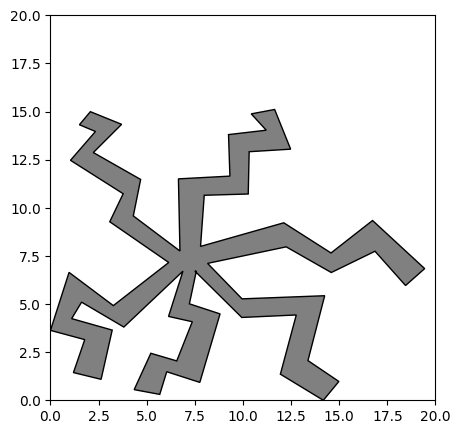

In [82]:
# Reverse the order of vertices to make it counter-clockwise
counter_clockwise_vertices = extract_vertices(svg_path_data)[::-1]
# Output the result
# print(counter_clockwise_vertices)

poly = Polygon(counter_clockwise_vertices)
# Scale factor
scale_factor = 0.08

# Apply the transformation
poly = affine_transform(poly, (scale_factor, 0, 0, scale_factor, 0, 0))

plot_map([poly], [0, 20], [0, 20])

# Write to file to pass to c++

In [11]:
# Write to a file
with open('polygons/' +shape_name+ '.txt', 'w') as f:
    f.write(str(len(poly.exterior.coords)) + '\n')
    for c in poly.exterior.coords[::-1]:
        f.write(str(c[0]) + ' ' + str(c[1]) + '\n')

# Run C++ partition

In [25]:
print('Input:', 'polygons/' +shape_name+ '.txt')
print('Output:', 'polygons/' +shape_name+ '_multi.json')

Input: polygons/tentacle.txt
Output: polygons/tentacle_multi.json


In [26]:
!g++ main.cpp polypartition.cpp -std=c++11 -o main

In [27]:
!./main < polygons/tentacle.txt > polygons/tentacle_multi.json

# Visualize

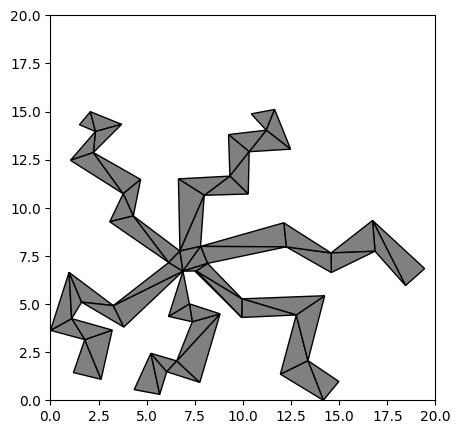

In [81]:
import json

with open('polygons/' +shape_name+ '_multi.json', 'r') as f:
    data = json.load(f)

polygons = data['polygons']

# for polygon in polygons:
#     print(polygon)

poly_l = []
for vertices in polygons:
    poly_l.append(Polygon(vertices))
plot_map(poly_l, [0, 20], [0, 20])